# 비지도 학습
> 레이블이 달린 데이터를 이용해 모델을 학습하는 과정 없이 데이터로부터 의미를 이끌어 내는 통계적 기법으로 응답 변수와 예측 변수 사이의 구분이 없다.

## 비지도 학습의 목적
레이블이 정해진 응답 변수가 없는 상태에서 예측 규칙을 만드는데 사용한다.
데이터의 의미 있는 그룹을 찾기 위해 **클러스터링**을 사용한다.

- 웹사이트에서 사용자의 클릭 데이터와 인구 통계 정보를 이용해 사용자들을 그룹화하여 웹사이트를 그룹의 기호에 맞게 개선한다.
- **콜드 스타트 문제**에서 유용한 방법으로 새로운 마케팅 전략 개발이나 사기나 스팸을 걸러내는 유형의 문제에서 응답 데이터를 가지고 있지 않을 때 패턴 기준으로 데이터를 분류한다.
- 작은 부모집단<sup>subpopulation</sup>이 전체 모집단을 잘 대표하지 못하면 미리 학습된 모델은 이 부모집단에 대해 나쁜 성능을 보이는데 클러스터링을 이용해 부모집단을 식별하고 레이블을 지정하여 분리된 부모 집단들을 각각 다른 모델에 피팅 할 수 있고 반대로 전체 모델이 부모 집단 정보를 명시적으로 예측 변수로 고려하게 할 수 있다.
데이터의 변수들을 관리 할 수 있을만한 수준으로 **차원을 줄이고** 이를 회귀 또는 분류 같은 예측 모델의 입력으로 사용 한다.
- 제조 공정을 모니터링 하기 위해 수천개의 센서를 사용. 공정 실패를 예측하는 모델을 만들고자 할 때 전체 데이터의 차원을 작은 차원의 의미 있는 피처 데이터로 줄일 수 있다면 더 가볍고 해석하기 쉬운 모델을 만들 수 있다.
탐색적 데이터 분석의 연장으로 데이터와 다른 변수들 사이에 어떤 관계가 있는지를 파악 한다.


## 주성분 분석
> 주어진 데이터의 고유한 주성분<sup>Principal Component</sup>을 찾아 데이터를 새로운 공간으로 변환하여 차원을 축소하는 기술

- 공변<sup>covary</sup>으로 한 변수 값의 변화는 다른 변수의 변화와 중복된다.(식당의 음식 값과 팁)
- 데이터의 차원이 4차원 이상일 경우 해석이 어렵다.
- PCA를 통해 주성분을 찾고 높은 설명력을 보이는 주성분들을 기준으로 데이터 차원을 축소 할 수 있다.

In [63]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

%matplotlib inline

DATA = Path().resolve() / 'datasets'

SP500_DATA_CSV = DATA / 'sp500_data.csv.gz'
SP500_SECTORS_CSV = DATA / 'sp500_sectors.csv'
LOAN_DATA_CSV = DATA / 'loan_data.csv.gz'
HOUSE_TASKS_CSV = DATA / 'housetasks.csv'

## 주성분 계산
석유 및 가스기업 2곳의 주식 변화량 데이터를 이용한 PCA
```
Exxon Mobil(XOM) : 세계 최대 석유 회사   
Chevron Corporation(CVX) : 캘리포니아 최대 석유 및 천연가스 회사로 자회사 칼텍스를 통해 한국에 진출
```

첫번째 차트의 두 점선은 각각의 주성분의 방향으로 첫번째 주성분인 장축을 통해 대부분의 변동성을 설명 가능 하다.

In [64]:
sp500_px = pd.read_csv(SP500_DATA_CSV, index_col=0)
oil_px = sp500_px[['XOM', 'CVX']]
print("일자별 주식 변화량\n", oil_px.head())

pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print("\nPCA 결과\n", loadings)

일자별 주식 변화량
                  XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272

PCA 결과
         XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


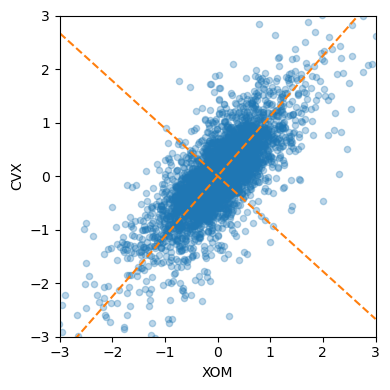

In [65]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

## 주성분 해석
- 주성분의 상대적인 중요도를 표시하는 스크리그래프<sup>scree graph</sup>를 이용해 시각화 할 수 있다.

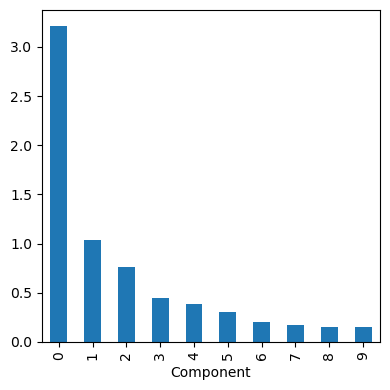

In [66]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [67]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

- 상위 다섯개 성분의 부하를 보여주고 부하의 부호에 따라 주가의 관계를 판단 할 수 있다.

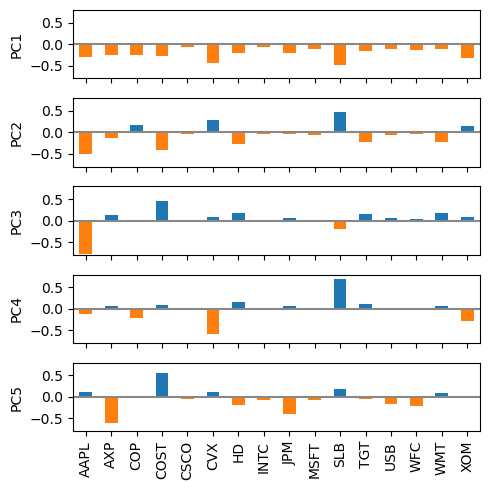

In [68]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### PCA를 이용한 차원 축소 및 2차원 투영
- 아이리스 데이터 세트는 꽃받침 길이, 꽃받침 너비, 꽃잎 길이, 꽃잎 너비의 4가지 속성을 가진 3가지 종류의 아이리스 꽃 데이터
- 4개의 주성분 중 상위 2개의 주성분이 93%의 설명력을 가지고 있으므로 2개의 주성분으로 2차원에 데이터를 투영하였다.
    - 4가지 속성을 시각화하여 분석하기는 어려우나 상위 주성분을 이용해 2차원 그래프로 표시하면 데이터 분석이 용이하다.
    - 성분을 고르는 기준은 정해져있지 않으며 상위 몇개의 주성분을 고르거나 누적 분산의 임계치로 선정 할 수 있다.

explained variance ratio (all components): [0.92461872 0.05306648 0.01710261 0.00521218]


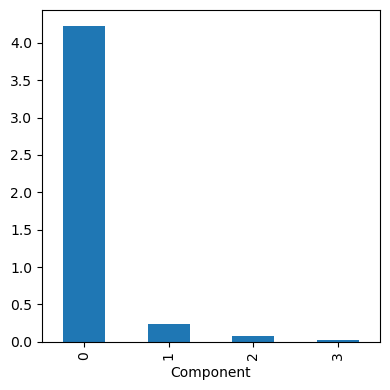

In [69]:
from sklearn import datasets
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

iris = datasets.load_iris()

X = iris.data
y = iris.target
target_names = iris.target_names

ac_pca = PCA()
ac_pca.fit(X)

print(
    "explained variance ratio (all components): %s"
    % str(ac_pca.explained_variance_ratio_)
)
explained_variance = pd.DataFrame(ac_pca.explained_variance_)
ax = explained_variance.plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

explained variance ratio (first two components): [0.92461872 0.05306648]


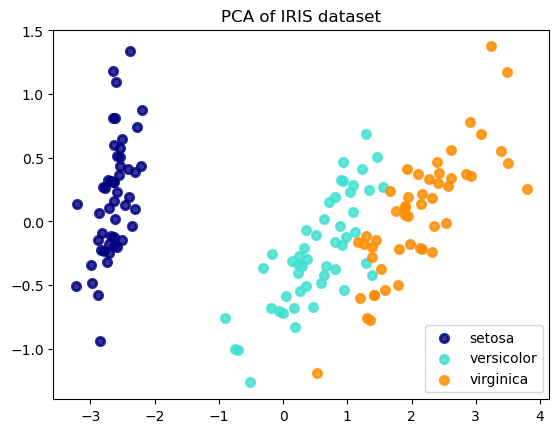

In [70]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

print(
    "explained variance ratio (first two components): %s"
    % str(pca.explained_variance_ratio_)
)

plt.figure()
colors = ["navy", "turquoise", "darkorange"]
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2], target_names):
    plt.scatter(
        X_r[y == i, 0], X_r[y == i, 1], color=color, alpha=0.8, lw=lw, label=target_name
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA of IRIS dataset")

plt.show()

## 대응분석
- 범주형 데이터에 사용 할 수 있는 기술으로 범주간, 범주형 피처 간의 연관성을 인식하는 것이다.
- 저차원 범주형 데이터의 그래프 분석에 이용되며 서로 연관된 변수를 근접도에 따라 표시한다.

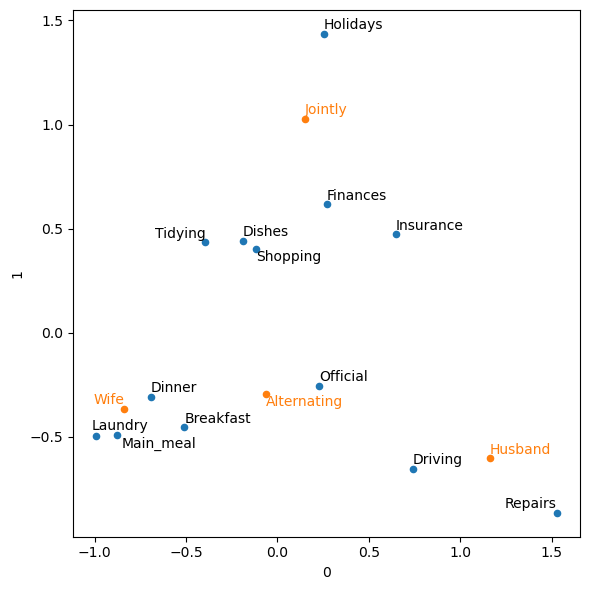

In [71]:
from adjustText import adjust_text

housetasks = pd.read_csv(HOUSE_TASKS_CSV, index_col=0)

ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ax = ca.row_coordinates(housetasks).plot.scatter(x=0, y=1, figsize=(6,6))
ca.column_coordinates(housetasks).plot.scatter(x=0, y=1, ax=ax, c='C1')
texts = []
for idx, row in ca.row_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx))
for idx, row in ca.column_coordinates(housetasks).iterrows():
    texts.append(plt.text(row[0], row[1], idx, color='C1'))
adjust_text(texts, only_move={'points':'y', 'texts':'y'}) 
plt.tight_layout()
plt.show()

### 대응 분석의 주요 개념
- 주성분은 예측 변수들의 선형 결합이다.
- 주성분끼리는 상관관계가 최소화되고 중복성이 줄어들도록 한다.
- 제한된 개수의 주성분들로도 결과변수에서 대부분의 변동을 설명 할 수 있다.
- 제한된 개수의 주성분들을 차원이 감소된 형태로 사용 할 수 있다.
- 빅데이터에서는 유용하지 않다.

## K-평균 클러스터링

- 클러스터링은 데이터를 서로 다른 그룹으로 분류하는 기술을 말한다.
- K-Means는 최초로 개발된 클러스터링 기법으로 간단한 알고리즘과 데이터 크기에 구애받지 않아 널리 사용된다.

In [72]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        2
2011-01-04  0.168668 -0.584516        3
2011-01-05  0.026631  0.446985        2
2011-01-06  0.248558 -0.919751        3
2011-01-07  0.337329  0.180511        2


In [73]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0 -1.137958 -1.746642
1  0.960948  1.376572
2  0.242519  0.336479
3 -0.328125 -0.564848


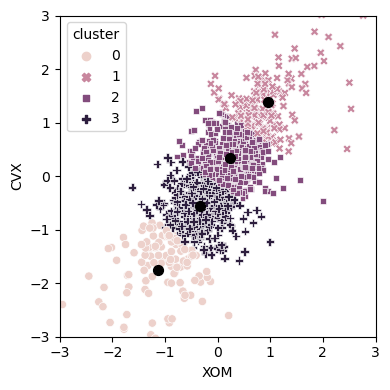

In [74]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

### K-평균 알고리즘
- 클러스터의 수 K를 정한다.
- 각 클러스터의 중심을 무작위로 선택한다.
- 각 레코드를 가장 가까운 평균을 갖는 클러스터에 할당한다.
- 클러스터의 평균을 새로 계산한다.
- 클러스터의 평균이 변하지 않을 때까지 반복한다.

In [75]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
# 사이킷런에서는 알고리즘을 10번 반복한다.
kmeans = KMeans(n_clusters=5).fit(top_sp)

### 클러스터 해석
- 클러스터를 바르게 해석하기 위해 가장 중요한 두 출력은 크기와 클러스터 평균이다.
- 클러스터 평균 차트는 PCA의 부하그래프와 비슷하지만 부호가 매우 중요한 의미를 가진다.

In [76]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({4: 289, 2: 285, 3: 277, 0: 173, 1: 107})


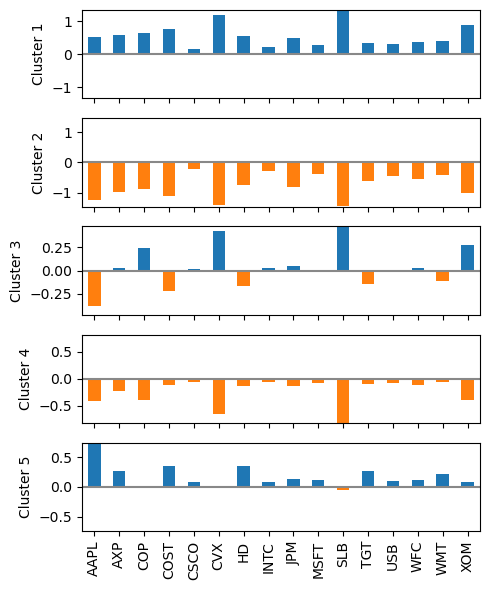

In [77]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

### 클러스터 개수 선정
- 실무 혹은 관리상의 고려에 따라 클러스터 개수를 정할 수 있다.
- 통계적 접근 방식으로 **팔꿈치 방법**을 사용 할 수 있다.
- 클러스터가 새로운 데이터에서도 유지되는지, 해석 가능한지, 일반적인 특성과 관련이 있는지를 고려한다.

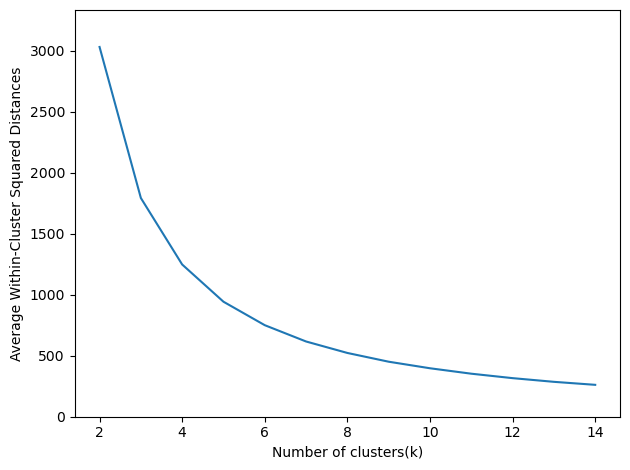

In [78]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    # inertia_ 속성은 각 데이터가 속한 클러스터의 중심과의 거리의 합
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

## 계층적 클러스터링
- 계층적 클러스터링은 클러스터의 개수를 미리 정하지 않고 클러스터를 계층적으로 구성한다.
- 대규모 데이터에는 적합하지 않다.

- 주요 용어
    - 덴드로 그램<sup>dendrogram</sup> : 계층적 클러스터링의 결과를 시각화하는데 사용
    - 거리<sup>distance</sup> : 레코드 간의 유사도
    - 비유사도<sup>dissimilarity</sup> : 클러스터 간의 유사도

### 간단한 예제
- 각 레코드를 하나의 클러스터로 간주하고 가장 가까운 레코드 쌍을 찾아 클러스터를 합친다.

In [79]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
# 행이 주가가 되도록 변환
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

(17, 4)


### 덴드로그램
- 덴드로그램은 계층적 클러스터링의 결과를 시각화하는데 사용한다.
- 트리의 잎은 레코드를 나타내고 가지 길이는 클러스터 간의 거리를 나타낸다.
- 클러스터의 수를 미리 정할 필요가 없다.

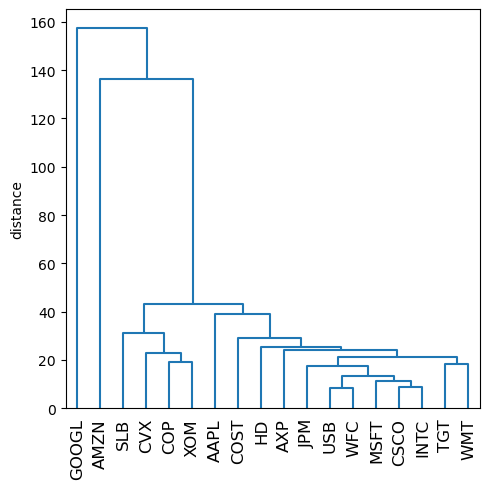

In [80]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [81]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

1 : COP, CVX, SLB, XOM
2 : AAPL, AXP, COST, CSCO, HD, INTC, JPM, MSFT, TGT, USB, WFC, WMT
3 : AMZN
4 : GOOGL


## 병합 알고리즘
- 병합 알고리즘은 계층적 클러스터링을 위해 사용되는 알고리즘이다.
- 단일 레코드로 구성된 클러스터 부터 시작해서 점점 더 큰 클러스터들을 만든다.

### 병합 알고리즘의 단계
- 각 레코드를 하나의 클러스터로 간주한다.
- 가장 가까운 레코드 쌍을 찾아 클러스터를 합친다.
- 클러스터 간의 거리를 계산한다.
- 클러스터 간의 거리가 미리 정한 임계치보다 작으면 알고리즘을 종료한다.
- 그렇지 않으면 2단계로 돌아간다.

### 비유사도 측정
비유사도 측정은 두 클러스터 간의 거리를 계산하는 방법이며 일반적인 지표는 완전연결, 단일연결, 평균연결, 워드 기법이다.
- 완전연결은 비슷한 멤버가 있는 클러스터를 만드는 경향이 있다.
- 단일 연결 방법은 두 클러스터의 레코드간 최소 거리를 사용하는 방식이다. 탐욕적인 방법(주어진 정보 내에서 최선을 선택)으로 크게 다른 요소를 포함할 수도 있다.
- 평균 연결 방법은 모든 거리 쌍의 평균을 사용하는 방법으로 단일 연결과 완전 연결법 사이를 절충한 방법이다.
- 워드 기법은 클러스터 내의 제곱합을 최소화 하므로 K-평균 알고리즘과 유사하다.


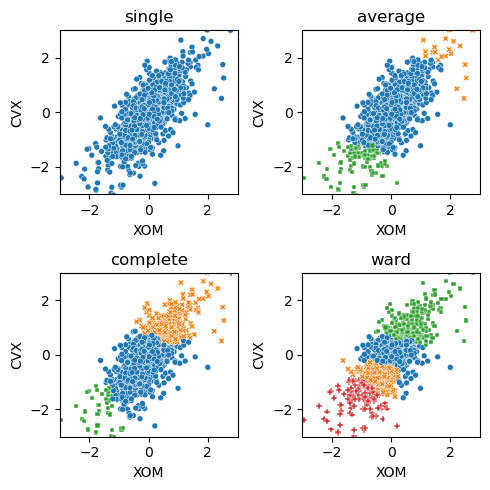

In [82]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()

## 모델 기반 클러스터링
> 계층적 클러스터링과 k-평균 알고리즘은 모두 휴리스틱한 방법으로 클러스터를 생성합니다.
>
> 모델 기반 클러스터링은 클러스터의 모델을 정의하고 각 레코드가 어떤 모델에 가장 잘 맞는지를 결정합니다.

### 다변량 정규 분포
- 다변량 정규 분포에서는 데이터가 더 이상 하나의 숫자가 아니라 여러 숫자로 이루어진 벡터로 나타납니다.
- 이 데이터는 하나의 중심점(평균)을 가지며, 그 주위로 데이터가 모여 있습니다. 중심점은 벡터 형태로 나타납니다.
- 데이터 포인트들은 중심점을 중심으로 분포되며, 중심점에서 멀어질수록 데이터가 희미해집니다.
- 데이터 포인트들 사이에는 서로 연관되는 패턴이 있을 수 있으며, 이것은 공분산 행렬로 나타납니다.

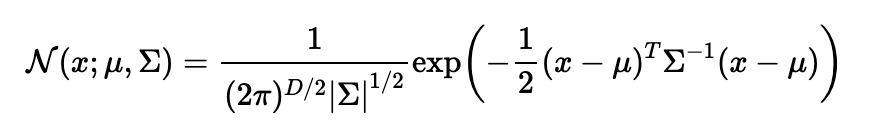
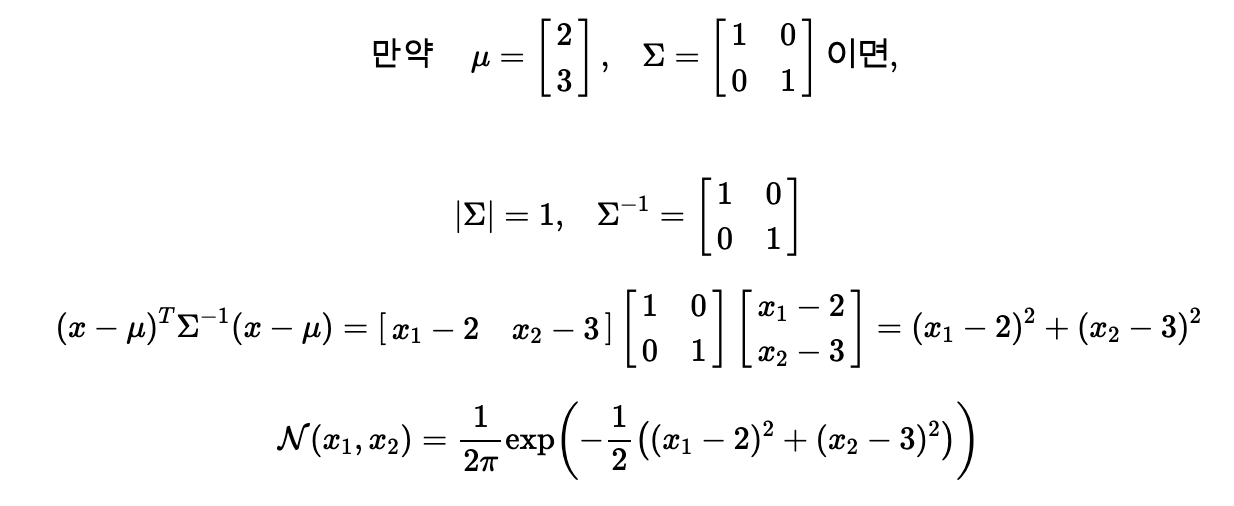

In [109]:
mu = [2, 3]
cov = [[1, 0], [0, 1]]

print("공분산 행렬의 스칼라값", np.linalg.det(cov))
print("공분산 행렬의 역행렬", np.linalg.inv(cov))

공분산 행렬의 스칼라값 1.0
공분산 행렬의 역행렬 [[1. 0.]
 [0. 1.]]


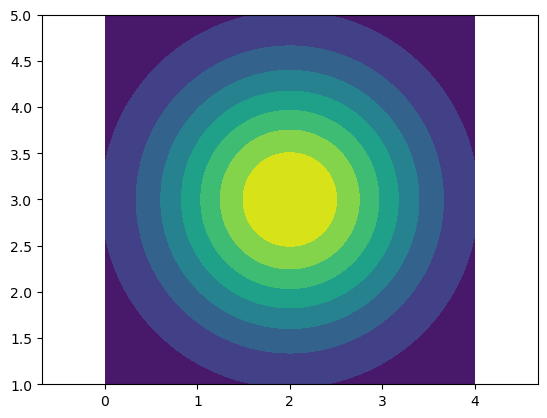

In [110]:
rv = multivariate_normal(mu, cov)

xx = np.linspace(0, 4, 120)
yy = np.linspace(1, 5, 150)

## xx, yy 같은 shape의 벡터 → XX, YY 서로 같은 매트릭스로 변환
# meshgrid : 벡터를 행렬로 변환
XX, YY = np.meshgrid(xx, yy)

plt.grid(False)
plt.contourf(XX, YY, rv.pdf(np.dstack([XX, YY])))
plt.axis("equal")
plt.show()

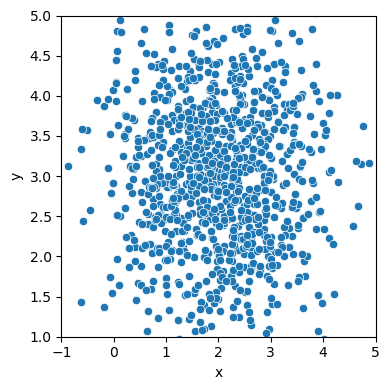

In [111]:
x, y = np.random.multivariate_normal(mu, cov, 1000).T
df = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x='x', y='y', data=df, ax=ax)
ax.set_xlim(-1, 5)
ax.set_ylim(1, 5)

plt.tight_layout()
plt.show()

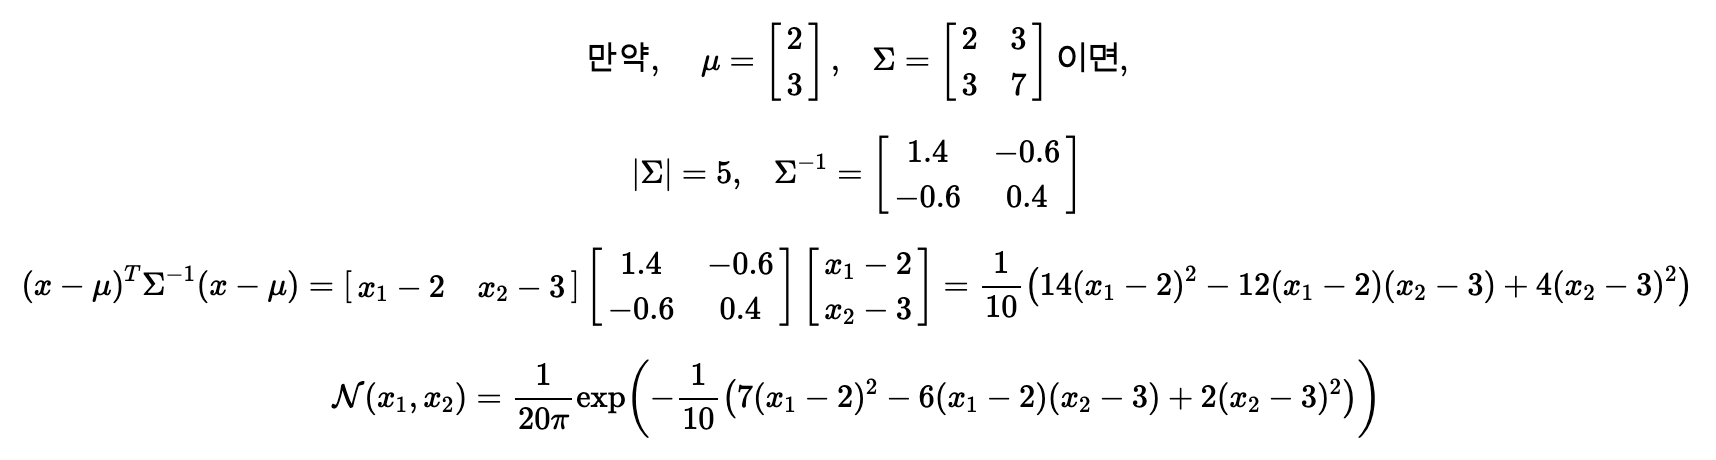

In [103]:
mu = [2, 3]
cov = [[2, 3],[3, 7]]

print("공분산 행렬의 스칼라값", np.linalg.det(cov))
print("공분산 행렬의 역행렬", np.linalg.inv(cov))

공분산 행렬의 스칼라값 5.000000000000001
공분산 행렬의 역행렬 [[ 1.4 -0.6]
 [-0.6  0.4]]


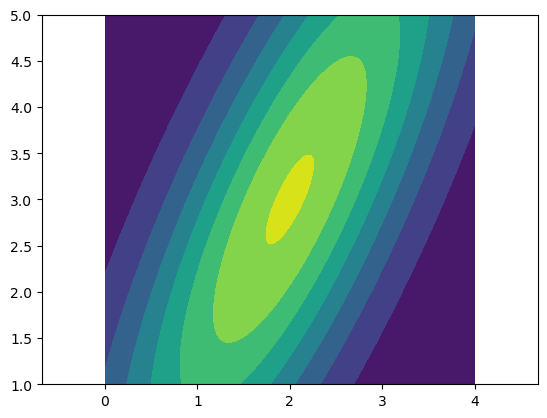

In [91]:
rv = multivariate_normal(mu, cov)
xx = np.linspace(0, 4, 120)
yy = np.linspace(1, 5, 150)

## xx, yy 같은 shape의 벡터 → XX, YY 서로 같은 매트릭스로 변환
# meshgrid : 벡터를 행렬로 변환
XX, YY = np.meshgrid(xx, yy)
plt.grid(False)
plt.contourf(XX, YY, rv.pdf(np.dstack([XX, YY])))
plt.axis("equal")
plt.show()

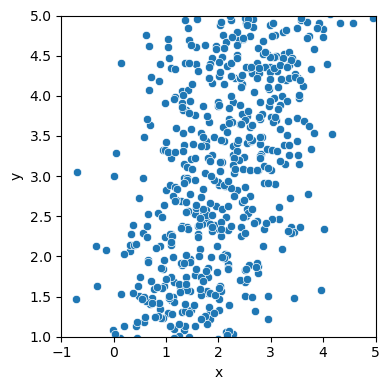

In [107]:
x, y = np.random.multivariate_normal(mu, cov, 1000).T
df = pd.DataFrame({'x': x, 'y': y})

fig, ax = plt.subplots(figsize=(4, 4))

ax = sns.scatterplot(x='x', y='y', data=df, ax=ax)
ax.set_xlim(-1, 5)
ax.set_ylim(1, 5)

plt.tight_layout()
plt.show()

찌그러진 정도가 적을수록( 원에 가까울 수록) → 상관계수 = 0

찌그러진 정도가 클수록 → 상관계수 = 1

## 정규 혼합
- 모델 기반 클러스터링의 핵심 개념은 각 레코드가 k개의 다변량정규분포 중 하나로부터 발생했다고 가정하는 것이다.
- k가 바로 클러스터의 개수이다.

In [84]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
mclust = GaussianMixture(n_components=2).fit(df)
print(mclust.bic(df))

4589.928857318638


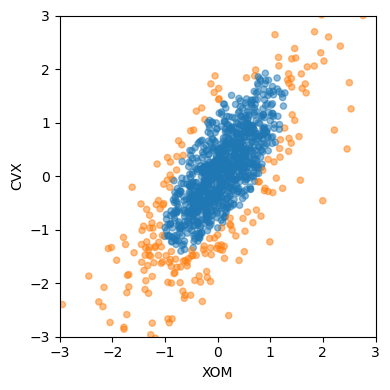

In [85]:
fig, ax = plt.subplots(figsize=(4, 4))
colors = [f'C{c}' for c in mclust.predict(df)]
df.plot.scatter(x='XOM', y='CVX', c=colors, alpha=0.5, ax=ax)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()

In [86]:
print('Mean')
print(mclust.means_)
print('Covariances')
print(mclust.covariances_)

Mean
[[ 0.07246995  0.10494619]
 [-0.05031426 -0.21161823]]
Covariances
[[[0.26822676 0.27562091]
  [0.27562091 0.51679853]]

 [[0.97123064 0.97764343]
  [0.97764343 1.67233845]]]


## 클러스터 개수 결정

- k-평균이나 계층적 클러스터링과 다르게, 모델 기반 클러스터링은 클러스터를 추가하면 할수록 파라미터의 개수도 많아지지면 적합도도 좋아진다.
- BIC 값을 주로 이용하여 엘보우 방법을 시행해서 선택한다.

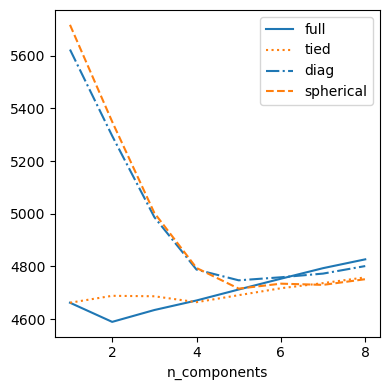

In [87]:
results = []
covariance_types = ['full', 'tied', 'diag', 'spherical']
for n_components in range(1, 9):
    for covariance_type in covariance_types:
        mclust = GaussianMixture(n_components = n_components, warm_start=True,
                                 covariance_type = covariance_type)
        mclust.fit(df)
        results.append({
            'bic': mclust.bic(df),
            'n_components': n_components,
            'covariance_type': covariance_type,
        })
        
results = pd.DataFrame(results)

colors = ['C0', 'C1', 'C2', 'C3']
styles = ['C0-','C1:','C0-.', 'C1--']

fig, ax = plt.subplots(figsize=(4, 4))
for i, covariance_type in enumerate(covariance_types):
    subset = results.loc[results.covariance_type == covariance_type, :]
    subset.plot(x='n_components', y='bic', ax=ax, label=covariance_type, 
                kind='line', style=styles[i]) # , color=colors[i])

plt.tight_layout()
plt.show()

# 스케일링과 범주형 변수
- 비지도 학습에서는 데이터를 적절하게 스케일해야 한다.
- 범주형 데이터는 클러스터링 과정에서 문제를 일으킬 수 있다.
- 일반적으로 원-핫 인코딩(0과 1로 이루어진 행렬)을 통해서 이진 변수 집합으로 변환한다.
- 이는 두 가지 값만 가지기 때문에 클러스터링에서 문제가 생길 수 있다.
## 변수 스케일링
- 단위가 많이 다르면 데이터를 먼저 정규화해야 한다.

In [112]:
loan_data = pd.read_csv(LOAN_DATA_CSV)
loan_data['outcome'] = pd.Categorical(loan_data['outcome'], 
                                      categories=['paid off', 'default'], 
                                      ordered=True)
defaults = loan_data.loc[loan_data['outcome'] == 'default',]

columns = ['loan_amnt', 'annual_inc', 'revol_bal', 'open_acc', 
           'dti', 'revol_util']

df = defaults[columns]
kmeans = KMeans(n_clusters=4, random_state=1).fit(df)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(kmeans.cluster_centers_, columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti  \
0  18275.132345   83354.634595  19635.189254  11.664373  16.774586   
1  21852.701005  165407.730318  38907.295645  12.597152  13.466876   
2  10591.893792   42453.058692  10268.048598   9.583820  17.713563   
3  22570.192308  489783.403846  85161.346154  13.326923   6.907500   

   revol_util   size  
0   62.258588   7543  
1   63.634900   1194  
2   58.111226  13882  
3   59.651923     52  


In [ ]:
scaler = preprocessing.StandardScaler()
df0 = scaler.fit_transform(df * 1.0)

kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
counts = Counter(kmeans.labels_)

centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=columns)
centers['size'] = [counts[i] for i in range(4)]
print(centers)

      loan_amnt     annual_inc     revol_bal   open_acc        dti   
0  10506.814810   51114.024278  11634.707310   7.509576  15.933778  \
1  10323.453512   53466.038196   6052.642631   8.664617  11.309106   
2  25950.205142  116834.142232  32945.972921  12.396335  16.165914   
3  13486.397177   55905.907924  16435.679660  14.322746  24.210014   

   revol_util  size  
0   77.784329  7399  
1   30.990055  5357  
2   66.123542  3671  
3   59.462324  6244  


## 지배 변수
- 변수의 단위가 모두 동일하고 상대적 중요성을 정확하게 반영하는 경우에도 변수의 스케일을 재조정하는 것이 유용할 수 있다.
- 전체 데이터에 영향을 미치는 지배적인 데이터의 경우 스케일링을 통해 요소의 분산을 찾아내는 것.
- 이 지배 변수를 배제하느냐 포함하느냐는 분야에 따라 다르다.

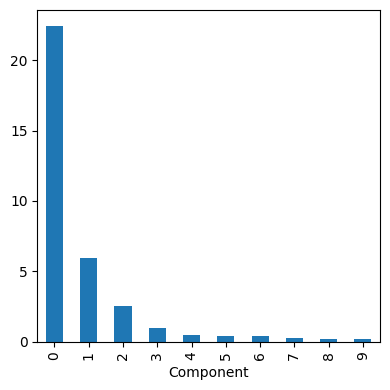

In [ ]:
syms = ['GOOGL', 'AMZN', 'AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 
        'SLB', 'COP', 'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST']
top_sp1 = sp500_px.loc[sp500_px.index >= '2005-01-01', syms]

sp_pca1 = PCA()
sp_pca1.fit(top_sp1)

explained_variance = pd.DataFrame(sp_pca1.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [ ]:
loadings = pd.DataFrame(sp_pca1.components_[0:2, :], 
                        columns=top_sp1.columns)
print(loadings.transpose())

              0         1
GOOGL -0.857310  0.477873
AMZN  -0.444728 -0.874149
AAPL  -0.071627 -0.020802
MSFT  -0.036002 -0.006204
CSCO  -0.029205 -0.003045
INTC  -0.026666 -0.006069
CVX   -0.089548 -0.037420
XOM   -0.080336 -0.020511
SLB   -0.110218 -0.030356
COP   -0.057739 -0.024117
JPM   -0.071228 -0.009244
WFC   -0.053228 -0.008597
USB   -0.041670 -0.005952
AXP   -0.078907 -0.024027
WMT   -0.040346 -0.007141
TGT   -0.063659 -0.024662
HD    -0.051412 -0.032922
COST  -0.071403 -0.033826


## 범주형 데이터와 고워 거리
> 데이터를 구성하는 변수들에 연속형과 이진형이 섞여 있으면 스케일링의 기준으로 고워 거리를 이용하는 게 대표적이다.

### 고워 거리
- 기본적인 개념은 각 변수형 데이터 유형에 따라 지표를 다르게 적용하는 것이다.
    - 수치형이나 범주형 변수에서 두 레코드의 거리는 차이의 절댓값 (맨해튼 거리)로 계산한다.
    - 범주형 변수는 다르면 거리가 1, 같으면 0이다.

계산은 다음과 같다.

- 각 레코드의 변수의 거리를 계산한다.
- 각 거리를 최소 0, 최대 1이 되도록 스케일링한다.
- 거리 행렬을 구하기 위해 스케일된 거리를 모두 더하고 평균 혹은 가중평균을 계산한다.

In [ ]:
x = defaults[['dti', 'payment_inc_ratio', 'home_', 'purpose_']].loc[0:4, :]
print(x)

     dti  payment_inc_ratio home_            purpose_
0   1.00            2.39320  RENT      major_purchase
1   5.55            4.57170   OWN      small_business
2  18.08            9.71600  RENT               other
3  10.08           12.21520  RENT  debt_consolidation
4   7.06            3.90888  RENT               other


```

###############################################################
## Figure 7-13: Categorical data and Gower's distance

x <- loan_data[1:5, c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
x

daisy(x, metric='gower')

set.seed(301)
df <- loan_data[sample(nrow(loan_data), 250),
                c('dti', 'payment_inc_ratio', 'home_', 'purpose_')]
d = daisy(df, metric='gower')
hcl <- hclust(d)
dnd <- as.dendrogram(hcl)

png(filename=file.path(PSDS_PATH, 'figures', 'psds_0713.png'), width = 4, height=4, units='in', res=300)
par(mar=c(0,5,0,0)+.1)
plot(dnd, leaflab='none', ylab='distance')
dev.off()

dnd_cut <- cut(dnd, h=.5)
df[labels(dnd_cut$lower[[1]]),]


## Problems in clustering with mixed data types
df <- model.matrix(~ -1 + dti + payment_inc_ratio + home_ + pub_rec_zero, data=defaults)
df0 <- scale(df)
km0 <- kmeans(df0, centers=4, nstart=10)
centers0 <- scale(km0$centers, center=FALSE, scale=1/attr(df0, 'scaled:scale'))
round(scale(centers0, center=-attr(df0, 'scaled:center'), scale=FALSE), 2)
```

## 혼합 데이터의 클러스터링 문제
- 혼합 데이터에서 z점수를 사용하면 이진 변수가 너무 큰 영향을 미친다. 따라서 혼합된 데이터에서 스케일링을 사용하지 않도록 조심해야 한다.


In [ ]:
columns = ['dti', 'payment_inc_ratio', 'home_', 'pub_rec_zero']
df = pd.get_dummies(defaults[columns])

scaler = preprocessing.StandardScaler()

df0 = scaler.fit_transform(df * 1.0)
kmeans = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(df0)
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                       columns=df.columns)
print(centers)

         dti  payment_inc_ratio  pub_rec_zero  home__MORTGAGE     home__OWN   
0  16.977575           9.055062      0.921301    1.282308e-14 -1.429412e-15  \
1  17.197993           9.266666      0.917903   -6.661338e-16  1.000000e+00   
2  21.796605          11.058379      0.975886    1.000000e+00 -3.885781e-16   
3  13.097357           5.778804      0.838922    1.000000e+00 -3.053113e-16   

     home__RENT  
0  1.000000e+00  
1  2.053913e-15  
2 -3.552714e-15  
3 -3.719247e-15  
